# <center> Classification using K Nearest Neighbor </center>

___

Knn is a LAZY LEARNER which means there is no in the training phase. During the test phase, distances are calculated for each test query w.r.t. all train data points. Out of these, N data points are picked to give a local approximation of target.

While Knn can be used for both `Classification` and `Regression` for any kind of data, it tends to be 
- slower, 
- requires high computational power and 
- gives lower accuracy, as compared to other powerful algorithms.

This kind of model is particularly useful when eager learning models are not suitable or there is no surety that training and testing data belongs to same distribution.

Some application areas where Knn is well-suited are :

- Semantic Search
- Recommendation Systems
- Face Detection or Fingerprint Detection

___


## Personal Loan Dataset

We will use [Personal Loan Dataset](https://www.kaggle.com/itsmesunil/bank-loan-modelling). This case is about a bank (Thera Bank) which has a growing customer base. The department wants to build a model that will help them identify the potential customers who have a higher probability of purchasing the loan. This will increase the success ratio while at the same time reduce the cost of the campaign.

| Feature | Description |
| --- | --- |
| ID | Customer ID |
| Age | Customer's age in completed year |
| Experience | # years of professional experience |
| Income | Annual income of the customer (1,000) |
| ZIPcode | Home address ZIP code |
| Family | Family size of the customer |
| CCAvg | Average monthly credit card spending (1, 000) |
| Education | Education level: 1: undergrad; 2, Graduate; 3; Advance/Professional |
| Mortgage | Value of house mortgage if any (1, 000) |
| Securities Acct | Does the customer have a securities account with the bank? |
| CD Account | Does the customer have a certifcate of deposit (CD) account with the bank? |
| Online | Does the customer use internet bank facilities? |
| CreditCard | Does the customer use a credit card issued by the Bank? |
| Personal loan | Did this customer accept the personal loan offered in he last campaign? 1, yes; 0, no (target variable) | 

#### The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

___

## Load the libraries

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
bank = pd.read_csv("UnivBank.csv")

bank.shape

(5000, 14)

There are a total of 5,000 customers in the data set and 14 variables. 

## Exploratory Data Analysis

Let us take a look at a portion of the data.

In [3]:
bank.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1.0,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1.0,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0.0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0.0,#,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0.0,0,0,1


We can figure that following columns are categorical type.

- Family ( ORDINAL )
- Education ( NOMINAL )
- Personal Loan `target column`
- Securities Account ( NOMINAL )
- CD Account ( NOMINAL )
- Online ( NOMINAL )
- Credit Card ( NOMINAL )

Let us check if all columns are in appropriate data format.

In [4]:
bank.dtypes

ID                      int64
Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage               object
Personal Loan           int64
Securities Account    float64
CD Account             object
Online                  int64
CreditCard              int64
dtype: object

<div class="alert alert-block alert-info"><b> 
    
- All nominal variables should be converted to category type. 
- Mortgage and CD Account should be float but pandas read it as object. This means there are some string type values.
</b></div>    

Let us verify which string values are present in these column.

In [5]:
bank["CD Account"].value_counts()

0    4697
1     302
#       1
Name: CD Account, dtype: int64

In [6]:
for col in ['Mortgage' , 'CD Account'] :
    print('\n', col, ' ----->>')
    for index in range(0, len(bank)):
        try :
            skip = float(bank.loc[index, col])
        except ValueError :
            print(index, bank.loc[index, col])


 Mortgage  ----->>
12 ?
19 ?

 CD Account  ----->>
3 #


As we can see all these string values are spaces. Let us read the data again and instruct pandas to read space as NA. 

In [7]:
bank = pd.read_csv('UnivBank.csv', na_values = ['?', '#'])
bank.dtypes

ID                      int64
Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage              float64
Personal Loan           int64
Securities Account    float64
CD Account            float64
Online                  int64
CreditCard              int64
dtype: object

Now, Mortgage and CD Account is correctly read as float.

<div class="alert alert-block alert-info"><b> 

- We will check if ID is unique then we will convert it to row index.
</b></div>    

In [8]:
bank.ID.nunique()

5000

In [9]:
bank.set_index('ID', inplace = True)

Let us seperate our numerical and categorical attributes.

In [10]:
cat_cols = ['Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard']

num_cols = bank.columns[~bank.columns.isin(cat_cols)]

print(num_cols)
num_cols = num_cols.delete(-1)
num_cols

Index(['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Mortgage', 'Personal Loan'],
      dtype='object')


Index(['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Mortgage'],
      dtype='object')

We shall check there are no invalid values in any of the categorical variables.

In [11]:
for x in cat_cols :
    print(x, '----->>', bank[x].unique(), '\n')

Education ----->> [1 2 3] 

Securities Account ----->> [ 1.  0. nan] 

CD Account ----->> [ 0. nan  1.] 

Online ----->> [0 1] 

CreditCard ----->> [0 1] 



In [12]:
bank[num_cols].describe()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Mortgage
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4998.000000
mean,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,56.521409
std,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,101.727873
min,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,0.000000
50%,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,0.000000
75%,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,101.000000
max,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,635.000000


<div class="alert alert-block alert-info"><b> 

- Experience cannot be negative.
</b></div>    

Let us see how many observations have negative experience.

In [13]:
bank[bank.Experience < 0].shape

(52, 13)

There are 52 observations with experience less than 0.

In [14]:
bank[bank.Experience < 0].groupby(['Age', 'Experience']).count()['Personal Loan']

Age  Experience
23   -3             2
     -2             4
     -1             6
24   -3             2
     -2             9
     -1             6
25   -2             1
     -1            17
26   -1             1
28   -2             1
29   -1             3
Name: Personal Loan, dtype: int64

Based on the Age-Experience break up, we can see that there is no way to understand these values.

- Experience -1 is assigned for each of these Age level.

We can check if everyone below Age 30 has negative experience value.

In [15]:
bank[(bank.Experience >= 0) & (bank.Age < 30)].shape

(436, 13)

There are 436 observation where customers with Age less than 30 have negative experience. 

Let us plot the relationship between average experience w.r.t Age.

In [16]:
df = pd.DataFrame(bank.groupby("Age").mean()["Experience"])
df

,Experience
Age,
23,-1.666667
24,-1.071429
25,-0.018868
26,0.961538
27,1.923077
28,2.961165
29,3.715447
30,4.860294
31,5.552000


In [17]:
df = pd.DataFrame(bank.groupby("Age").mean()["Experience"]).reset_index()
df

,Age,Experience
0,23,-1.666667
1,24,-1.071429
2,25,-0.018868
3,26,0.961538
4,27,1.923077
5,28,2.961165
6,29,3.715447
7,30,4.860294
8,31,5.552000
9,32,6.850000


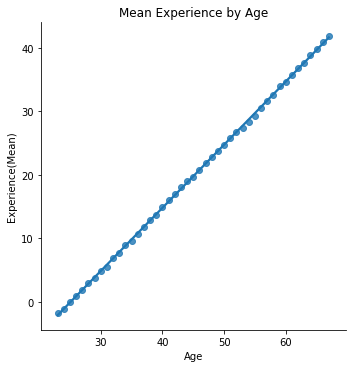

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(bank.groupby("Age").mean()["Experience"]).reset_index()

sns.lmplot(x = 'Age', y = 'Experience', data=df)
plt.ylabel("Experience(Mean)")
plt.title("Mean Experience by Age")
plt.show()

- We see a very linear plot. 
- Also, we have 3 specific values [-1, -2, -3] and not just any random values.

The experience value doesn't look random. 

> In such situations, it is critical to reach the client and ask for clarification.

We will not change these values for now as we don't see them to be invalid.

Let us check for number of NA values.

In [19]:
bank.isnull().sum()

Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              2
Personal Loan         0
Securities Account    2
CD Account            1
Online                0
CreditCard            0
dtype: int64

<div class="alert alert-block alert-info"><b> 
    
- As there are only 4 NA value, we can impute them with the mean / mode value .

</b></div>

We will seperate our independent variables and target variable.

In [20]:
X = bank.drop('Personal Loan', axis = 1)

y = bank["Personal Loan"]

### Function to prepare data

We will write a function to prepare data for following functions.

- Train and Test Split
- Fit the Imputer on Train Data
- Fit the Scaler on Train Data

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_imputer = SimpleImputer()
cat_imputer = SimpleImputer(strategy = 'most_frequent')
num_scaler = StandardScaler()

In [22]:
def prepare_data(X, y, split_size = 0.3) :
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, test_size = split_size)  
    
    num_imputer.fit(X_train[num_cols])
    cat_imputer.fit(X_train[cat_cols])
    num_scaler.fit(X_train[num_cols])
    
    return X_train, X_test, y_train, y_test

In [23]:
X_train, X_test, y_train, y_test = prepare_data(X, y, 0.2)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 12)
(1000, 12)
(4000,)
(1000,)


### Function to pre-process data

We will write a function to pre-process data for following functions. This function will be called to transform both train and test datasets.

- Impute the numerical and categorical features
- Scale the numerical features
- Dummify the categorical features

We are adding an argument for scale so that we can choose whether to scale or not.

In [25]:
def preprocess_data(data, scale = False) :
    
    data[num_cols] = num_imputer.transform(data[num_cols])
    data[cat_cols] = cat_imputer.transform(data[cat_cols])
    
    if scale == True :
        data[num_cols] = num_scaler.transform(data[num_cols])
    
    data[cat_cols] = data[cat_cols].astype('category')
    data = pd.get_dummies(data, drop_first = True)

    return data

In [26]:
X_train = preprocess_data(X_train)
X_train.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Mortgage,Education_2.0,Education_3.0,Securities Account_1.0,CD Account_1.0,Online_1.0,CreditCard_1.0
ID,,,,,,,,,,,,,
4071,58.0,33.0,70.0,94720.0,4.0,0.70,0.0,0,0,1,0,0,0
4535,41.0,17.0,83.0,94025.0,4.0,2.67,0.0,0,0,0,0,1,0
2260,24.0,0.0,82.0,90401.0,3.0,0.80,0.0,0,0,0,0,1,0
4523,31.0,5.0,29.0,90630.0,1.0,0.30,0.0,0,0,0,0,0,0
4824,46.0,21.0,115.0,95616.0,2.0,4.20,0.0,0,1,1,1,1,1


In [27]:
X_train.dtypes

Age                       float64
Experience                float64
Income                    float64
ZIP Code                  float64
Family                    float64
CCAvg                     float64
Mortgage                  float64
Education_2.0               uint8
Education_3.0               uint8
Securities Account_1.0      uint8
CD Account_1.0              uint8
Online_1.0                  uint8
CreditCard_1.0              uint8
dtype: object

In [28]:
X_test = preprocess_data(X_test)
X_test.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Mortgage,Education_2.0,Education_3.0,Securities Account_1.0,CD Account_1.0,Online_1.0,CreditCard_1.0
ID,,,,,,,,,,,,,
2796,51.0,25.0,91.0,92407.0,1.0,0.8,0.0,0,1,0,0,0,0
1717,32.0,8.0,200.0,91330.0,2.0,6.5,565.0,0,0,0,0,1,0
409,60.0,36.0,89.0,91745.0,2.0,2.8,0.0,0,0,0,0,1,0
3758,45.0,21.0,142.0,91101.0,1.0,1.4,0.0,1,0,0,0,1,0
271,60.0,36.0,63.0,94063.0,4.0,2.2,0.0,0,0,0,0,1,0


## Build Knn Model

___

### Function for Model Fit & Predict

We will write a function for following functions. 

- Fit the model on train data
- Perform cross-validation when needed
- Predict on train and test data

In [29]:
from sklearn.model_selection import GridSearchCV

def model_building(model, params = None, k = 1) :
    
    if params == None :
        model.fit(X_train, y_train)
        
        # return fitted model & train-test predictions
        return (model, model.predict(X_train), model.predict(X_test))
    
    else :
        model_cv = GridSearchCV(model, param_grid = params, cv = k)
        model_cv.fit(X_train, y_train)
        model = model_cv.best_estimator_
        
        # return and extra object for all cross validation operations
        return (model_cv, model, model.predict(X_train), model.predict(X_test))

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm = 'brute', n_neighbors = 3,
                           metric = "euclidean")

model, pred_train, pred_test = model_building(knn)

### Function to Evaluate Model

In [31]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [32]:
def model_evaluation(actuals, predictions, report = True) :
    
    print('\nConfusion Matrix :')
    print(confusion_matrix(actuals, predictions) ) 
    
    if report == True :
        print('\nReport : ')
        print(classification_report(actuals, predictions))
    
    print('\nAccuracy Score :', accuracy_score(actuals, predictions)) 
    print("------------------------------------------------------------------")

In [33]:
model_evaluation(y_train, pred_train,report=True)

model_evaluation(y_test, pred_test)


Confusion Matrix :
[[3547   67]
 [ 178  208]]

Report : 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3614
           1       0.76      0.54      0.63       386

    accuracy                           0.94      4000
   macro avg       0.85      0.76      0.80      4000
weighted avg       0.93      0.94      0.93      4000


Accuracy Score : 0.93875
------------------------------------------------------------------

Confusion Matrix :
[[869  37]
 [ 65  29]]

Report : 
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       906
           1       0.44      0.31      0.36        94

    accuracy                           0.90      1000
   macro avg       0.68      0.63      0.65      1000
weighted avg       0.88      0.90      0.89      1000


Accuracy Score : 0.898
------------------------------------------------------------------


In [34]:
def model_evaluation(actuals, predictions, report = False) :
    
    print('\nConfusion Matrix :')
    print(confusion_matrix(actuals, predictions) ) 
    
    if report == True :
        print('\nReport : ')
        print(classification_report(actuals, predictions))
    
    print('\nAccuracy Score :', accuracy_score(actuals, predictions)) 
    print("------------------------------------------------------------------")

In [35]:
model_evaluation(y_train, pred_train,report=False)

model_evaluation(y_test, pred_test)


Confusion Matrix :
[[3547   67]
 [ 178  208]]

Accuracy Score : 0.93875
------------------------------------------------------------------

Confusion Matrix :
[[869  37]
 [ 65  29]]

Accuracy Score : 0.898
------------------------------------------------------------------


Knn is heavily impacted by standardisation. We have seen the result without standardising the data. Let us now see the result after standardisation.

In [36]:
X_train, X_test, y_train, y_test = prepare_data(X, y, 0.2)

In [37]:
X_train = preprocess_data(X_train,scale= True)
X_train.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Mortgage,Education_2.0,Education_3.0,Securities Account_1.0,CD Account_1.0,Online_1.0,CreditCard_1.0
ID,,,,,,,,,,,,,
2514,0.587479,0.520916,-0.064294,-0.647196,-1.216637,-0.310423,-0.551077,0,1,0,0,0,0
656,0.412373,0.433326,-1.331807,-1.174734,-0.345900,-0.709237,-0.551077,0,1,0,0,0,0
2046,0.587479,0.696094,-0.654343,1.066163,1.395574,-0.595290,0.505327,1,0,0,0,1,0
4707,1.287901,1.396809,-1.441076,-0.312369,-0.345900,-0.538317,-0.551077,0,0,0,0,0,0
3417,1.375454,1.484398,-0.260977,0.531804,-1.216637,-1.108051,1.857918,1,0,0,0,1,0


In [38]:
X_test = preprocess_data(X_test, scale=True)
X_test.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Mortgage,Education_2.0,Education_3.0,Securities Account_1.0,CD Account_1.0,Online_1.0,CreditCard_1.0
ID,,,,,,,,,,,,,
4188,-1.338682,-1.318460,0.766147,0.642087,1.395574,0.145365,0.465835,1,0,0,0,0,1
1675,-0.725812,-0.792924,1.421757,1.499904,-0.345900,-0.652263,3.605427,1,0,0,0,1,0
4480,-1.163576,-1.055692,1.181367,-0.033252,-0.345900,1.358900,-0.551077,0,0,0,0,1,0
1774,-1.251129,-1.318460,-1.004002,-0.647196,1.395574,-0.652263,-0.551077,0,0,0,0,0,0
744,1.375454,1.484398,-0.741758,0.775108,1.395574,0.145365,-0.551077,0,0,1,1,1,1


## Build Knn Model

In [39]:
knn_2 = KNeighborsClassifier(algorithm = 'brute', n_neighbors = 5, metric = "euclidean")

model_2, pred_train_2, pred_test_2 = model_building(knn_2)

In [40]:
model_evaluation(y_train, pred_train_2)

model_evaluation(y_test, pred_test_2)


Confusion Matrix :
[[3608    3]
 [ 159  230]]

Accuracy Score : 0.9595
------------------------------------------------------------------

Confusion Matrix :
[[908   1]
 [ 50  41]]

Accuracy Score : 0.949
------------------------------------------------------------------


> We can see that simply by standardising the data our test accuracy increased by approximately 5%.

### Edited Knn

___

Implementation based on Wilson's editing technique.

This removes the outlier points in Knn. 

> Outlier in Knn is a point which has a different target w.r.t. other similar points.

In [41]:
!pip install imblearn --user

## imblearn uses Tensorflow at the backend.So install Tensorflow using:

!pip install Tensorflow

In [43]:
from imblearn.under_sampling import EditedNearestNeighbours

eknn = EditedNearestNeighbours()

X_res_eknn, y_res_eknn = eknn.fit_resample(X_train, y_train) 

print(X_res_eknn.shape)

(3848, 13)


For the given data, around 140 outliers points are removed.

In [44]:
# fit the knn classifier on the reduced data
eknn = model.fit(X_res_eknn, y_res_eknn)

pred_test = model.predict(X_test)

print(confusion_matrix(pred_test, y_test))

accuracy_score(y_test,pred_test)

[[905  44]
 [  4  47]]


0.952

### Condensed Knn

___

These removes points which do not help in prediction and keeps only the points that help in building the decision boundary.

> This technique takes more time in training but testing time reduces as many points are dropped.

In [45]:
from imblearn.under_sampling import CondensedNearestNeighbour

cknn = CondensedNearestNeighbour()

X_res_cknn, y_res_cknn = cknn.fit_resample(X_train, y_train) 

print(X_res_cknn.shape)

(731, 13)


In [46]:
# fit the knn classifier on the condensed data
cknn = model.fit(X_res_cknn, y_res_cknn)

pred_test = model.predict(X_test)

print(confusion_matrix(pred_test, y_test))

accuracy_score(y_test,pred_test)

[[874  27]
 [ 35  64]]


0.938

For the given data, around 3300 points are dropped yet the accuracy has not suffered much.

## Choosing the best K using Elbow Curve

___

In [47]:
err = []
k_val = []

# try K = 1 through K = 15
for k in range(1, 15, 2):
    
    knn = KNeighborsClassifier(n_neighbors = k)
    
    model_3, pred_train_3, pred_test_3 = model_building(knn)

    e = 1 - accuracy_score(y_test, pred_test_3)
    print('K -> ', k, 'Error -> ', e)
    
    err.append(e)
    k_val.append(k)
    

K ->  1 Error ->  0.039000000000000035
K ->  3 Error ->  0.04700000000000004
K ->  5 Error ->  0.051000000000000045
K ->  7 Error ->  0.05300000000000005
K ->  9 Error ->  0.05600000000000005
K ->  11 Error ->  0.06000000000000005
K ->  13 Error ->  0.061000000000000054


Text(0, 0.5, 'Error on test data')

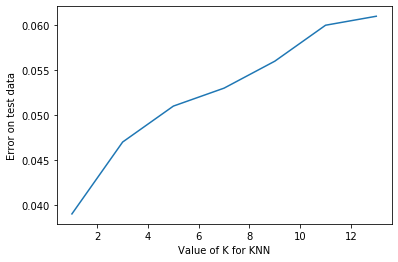

In [48]:
plt.plot(k_val, err)
plt.xlabel('Value of K for KNN')
plt.ylabel('Error on test data')

Build Knn Model with best k value from elbow curve.

In [49]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 3)

model_4, pred_train_4, pred_test_4 = model_building(knn)

In [50]:
model_evaluation(y_train, pred_train_4)

model_evaluation(y_test, pred_test_4)


Confusion Matrix :
[[3609    2]
 [ 242  147]]

Accuracy Score : 0.939
------------------------------------------------------------------

Confusion Matrix :
[[908   1]
 [ 60  31]]

Accuracy Score : 0.939
------------------------------------------------------------------


## Knn Classifier with Grid Search Crossvalidation 
___

> Hyper-parameter tuning

In [51]:
params = {"n_neighbors": [2, 5, 9],
          "metric": ["euclidean", "cityblock"]}

knn_5 = KNeighborsClassifier(algorithm = "brute", weights = "distance")

model_cv, model_5, pred_train_5, pred_test_5 = model_building(knn_5, params, 10)

In [52]:
model_cv.best_params_

{'metric': 'cityblock', 'n_neighbors': 2}

In [53]:

model_evaluation(y_train, pred_train_5)

model_evaluation(y_test, pred_test_5)


Confusion Matrix :
[[3611    0]
 [   0  389]]

Accuracy Score : 1.0
------------------------------------------------------------------

Confusion Matrix :
[[904   5]
 [ 32  59]]

Accuracy Score : 0.963
------------------------------------------------------------------


___